In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from modem import qpsk, chirp, wav
from modem.constants import FS, QPSK_BLOCK_LENGTH

In [2]:
rng = np.random.default_rng(seed=42)
NUM_BYTES = 1024
data_bytes = [bytes(rng.integers(255, size=NUM_BYTES, dtype=np.uint8)) for i in range(10)]
qpsk_symbols = [qpsk.qpsk_encode(data) for data in data_bytes]
ofdm_symbols = [qpsk.encode_ofdm_symbol(qpsk_syms) for qpsk_syms in qpsk_symbols]
signal = np.concatenate((chirp.START_CHIRP, *ofdm_symbols, chirp.END_CHIRP))

In [3]:
wav.generate_wav("chirp_white_noise.wav", signal)

Saved to C:\Users\jonti\SynologyDrive\Documents\Uni\IIA\Project-GF3\audio_modem_2025\src\modem\..\..\files\chirp_white_noise.wav


In [4]:
recv_signal = wav.read_wav("chirp_white_noise_recv.wav")

In [5]:
start_correlation = scipy.signal.convolve(recv_signal, chirp.START_CHIRP, mode="valid")
lags = scipy.signal.correlation_lags(recv_signal.size, chirp.START_CHIRP.size, mode="valid")
start_lag = lags[np.argmax(np.abs(start_correlation))]

end_correlation = scipy.signal.convolve(recv_signal, chirp.END_CHIRP, mode="valid")
lags = scipy.signal.correlation_lags(recv_signal.size, chirp.END_CHIRP.size, mode="valid")
end_lag = lags[np.argmax(np.abs(end_correlation))]

print(start_lag, end_lag, end_lag - start_lag, len(signal) - len(chirp.END_CHIRP))

197739 47296 -150443 150440


In [6]:
# TODO: why do we use end lag here, not start lag
aligned_recv_signal = np.roll(recv_signal, -end_lag)[:signal.size]

recv_ofdm_symbols = np.split(aligned_recv_signal[chirp.START_CHIRP.size:-chirp.END_CHIRP.size], len(ofdm_symbols))

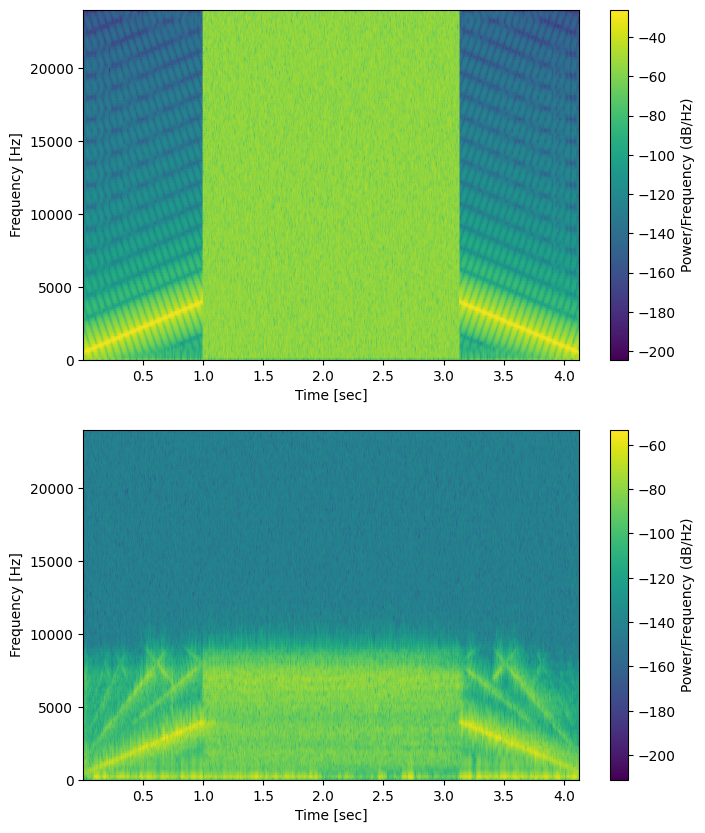

In [7]:
fig, axs = plt.subplots(2, figsize=(8, 10))
axs: tuple[plt.Axes]

for sig, ax in zip((signal, aligned_recv_signal), axs):
    f, t_spec, Sxx = scipy.signal.spectrogram(sig, FS)

    pcm = ax.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    cbar = fig.colorbar(pcm, ax=ax, label='Power/Frequency (dB/Hz)')

In [8]:
# Use all white noise blocks as pilot symbols and average all gains together
# TODO: in future, should allocate some to be data blocks and find error rate
frequency_gains = [(qpsk.decode_ofdm_symbol(recv_sym, np.ones(QPSK_BLOCK_LENGTH)) * np.conjugate(qpsk_syms)) / (qpsk_syms* np.conjugate(qpsk_syms))
                   for recv_sym, qpsk_syms in zip(recv_ofdm_symbols, qpsk_symbols)]
avg_gain = np.mean(frequency_gains, axis=0)

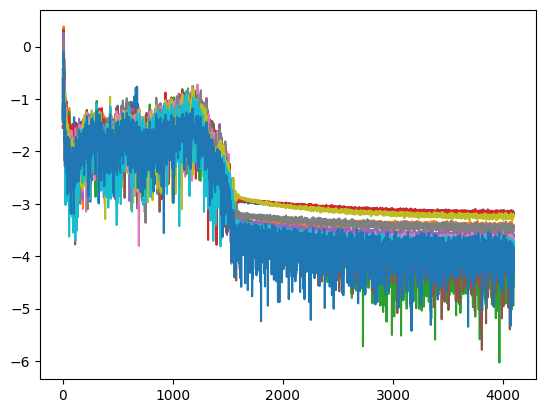

In [9]:
for block_gain in frequency_gains:
    plt.plot(np.log10(np.abs(block_gain)))
plt.plot(np.log10(np.abs(avg_gain)))

In [10]:
recv_qpsk_symbols = [qpsk.decode_ofdm_symbol(recv_sym, avg_gain) for recv_sym in recv_ofdm_symbols]

In [11]:
# Create boolean masks to color received symbols based on what the transmitted symbol was
positive_real_mask = np.real(qpsk_symbols[0]) > 0
positive_imag_mask = np.imag(qpsk_symbols[0]) > 0
mask_00 = np.logical_and(positive_real_mask, positive_imag_mask)
mask_01 = np.logical_and(~positive_real_mask, positive_imag_mask)
mask_11 = (~positive_real_mask) & (~positive_imag_mask)
mask_10 = positive_real_mask & (~positive_imag_mask)

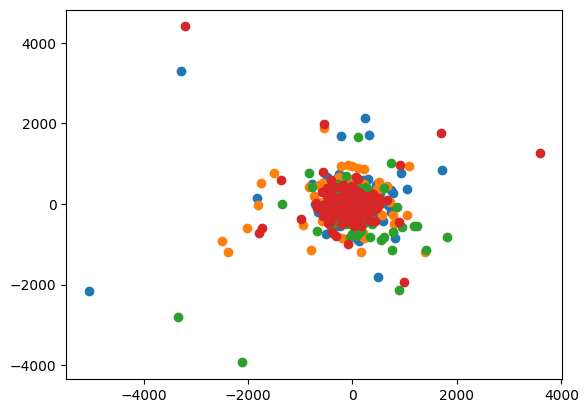

In [12]:
# Plot received symbols
for mask, bits in ((mask_00, "00"), (mask_01, "01"), (mask_10, "10"), (mask_11, "11")):
    plt.scatter(np.real(recv_qpsk_symbols[0][mask]), np.imag(recv_qpsk_symbols[0][mask]), label=bits)